# wRMSD calculation

This notebook analyzes the results of molecular dynamics simulations of antibody molecules.
It calculates the root-mean-square deviation (RMSD) between the candidate antibody and the reference antibody,
and uses this to calculate the weighted RMSD (wRMSD) based on the accessibility and movability of each residue.

The notebook requires the MDAnalysis library to be installed.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import MDAnalysis as mda

In [2]:
def read_xvg_file(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith(('#', '@')):
                continue
            
            data.append(line)

    return np.loadtxt(data)

In [3]:
# Define paths to the reference and candidates antibody simulation data
PATH_REFERENCE = 'md_simulations/remicade_humanization/remicade/'
PATH_CANDIDATE_Aa = 'md_simulations/remicade_humanization/candidate_Aa/'
PATH_CANDIDATE_Cb = 'md_simulations/remicade_humanization/candidate_Cb/'

# Define the CDR residues for the antibodies
CDRS = {
    'H1': (26, 33),    # 26-32
    'H2': (52, 60),    # 52-59
    'H3': (101, 110),  # 101-109
    'L1': (144, 155),  # 24-34
    'L2': (170, 177),  # 50-56
    'L3': (209, 218),  # 89-97
} 

In [4]:
# Load the reference and candidates antibody simulation data
reference = mda.Universe(os.path.join(PATH_REFERENCE, 'structures/newbox.gro'),
                         os.path.join(PATH_REFERENCE, 'prod_test/prod_test_noPBC_center.xtc')
                        )
candidate_Aa = mda.Universe(os.path.join(PATH_CANDIDATE_Aa, 'structures/newbox.gro'),
                            os.path.join(PATH_CANDIDATE_Aa, 'prod_test/prod_test_noPBC_center.xtc')
                           )
candidate_Cb = mda.Universe(os.path.join(PATH_CANDIDATE_Cb, 'structures/newbox.gro'),
                            os.path.join(PATH_CANDIDATE_Cb, 'prod_test/prod_test_noPBC_center.xtc')
                           )

reference, candidate_Aa, candidate_Cb

(<Universe with 3445 atoms>,
 <Universe with 3476 atoms>,
 <Universe with 3465 atoms>)

In [5]:
# Select the CDR residues and their alpha carbons for the reference and candidates antibodies
reference_cdr = sum([reference.residues[val[0] - 1:val[1] - 1].atoms for val in CDRS.values()])
reference_cdr_ca = reference_cdr.select_atoms('name CA')

candidate_Aa_cdr = sum([candidate_Aa.residues[val[0] - 1:val[1] - 1].atoms for val in CDRS.values()])
candidate_Aa_cdr_ca = candidate_Aa_cdr.select_atoms('name CA')

candidate_Cb_cdr = sum([candidate_Cb.residues[val[0] - 1:val[1] - 1].atoms for val in CDRS.values()])
candidate_Cb_cdr_ca = candidate_Cb_cdr.select_atoms('name CA')

reference_cdr_ca, candidate_Aa_cdr_ca, candidate_Cb_cdr_ca

(<AtomGroup with 51 atoms>,
 <AtomGroup with 51 atoms>,
 <AtomGroup with 51 atoms>)

$$RMSD_i = \sqrt{\frac{\sum_j \left(d_{ij} - d_{ij}^0 \right)^2}{n}}$$

$$wRMSD_i = \sum_i \frac{w_{i-accessibility} w_{i-movability} RMSD_i}{N}$$

$$w_{i-accessibility} = \frac{S_i}{S_{i.avg}}$$

$$w_{i-movability} = 1 / \left(\frac{RMSD_i^0}{RMSD_{i.avg}^0} \right)$$

In [12]:
# Define a function to calculate the distance matrix from a set of coordinates
def coordinates2distance_matrix(coordinates):
    return np.sqrt(np.sum((coordinates[:, np.newaxis, :] - coordinates[np.newaxis, :, :]) ** 2, axis=-1))


N = len(reference_cdr_ca)
n = N - 1
rmsd_Aa = []
rmsd_Cb = []

# Calculate the RMSD for each frame of the trajectories
for ts_ref, ts_cand_Aa, ts_cand_Cb in tqdm(zip(reference.trajectory,
                                               candidate_Aa.trajectory,
                                               candidate_Cb.trajectory,
                                              )):
    distance_matrix_ref = coordinates2distance_matrix(ts_ref[reference_cdr_ca.ix])
    distance_matrix_cand_Aa = coordinates2distance_matrix(ts_cand_Aa[candidate_Aa_cdr_ca.ix])
    distance_matrix_cand_Cb = coordinates2distance_matrix(ts_cand_Cb[candidate_Cb_cdr_ca.ix])
    rmsd_Aa.append(np.sqrt(np.sum((distance_matrix_cand_Aa - distance_matrix_ref) ** 2, axis=1) / n))
    rmsd_Cb.append(np.sqrt(np.sum((distance_matrix_cand_Cb - distance_matrix_ref) ** 2, axis=1) / n))

rmsd_Aa = np.array(rmsd_Aa)
rmsd_Cb = np.array(rmsd_Cb)
print(rmsd_Aa.shape, rmsd_Cb.shape)
rmsd_Aa, rmsd_Cb

0it [00:00, ?it/s]

(5001, 51) (5001, 51)


(array([[1.9732078 , 2.1445253 , 2.0732265 , ..., 1.2425034 , 1.0991746 ,
         0.93604314],
        [1.7039407 , 1.7378985 , 1.8898673 , ..., 1.085418  , 1.0500089 ,
         0.7513767 ],
        [1.5913863 , 1.6245046 , 1.6598512 , ..., 1.1067692 , 0.79253805,
         0.6769113 ],
        ...,
        [2.0031471 , 2.14137   , 1.6950476 , ..., 1.1522524 , 1.0573704 ,
         0.7840873 ],
        [2.1550474 , 1.9671093 , 2.0468762 , ..., 1.2702237 , 1.2794487 ,
         0.90414464],
        [1.9909657 , 1.7222009 , 1.9956936 , ..., 1.4017828 , 1.2498035 ,
         0.93454665]], dtype=float32),
 array([[1.411139  , 1.3693521 , 1.1787947 , ..., 1.1504655 , 0.9270746 ,
         0.8237213 ],
        [1.30349   , 1.2990162 , 1.1230302 , ..., 1.1931247 , 1.0577717 ,
         0.8521568 ],
        [1.3062311 , 1.3343085 , 1.256381  , ..., 1.0864326 , 0.9708562 ,
         0.93719536],
        ...,
        [1.8869256 , 1.641349  , 1.1661123 , ..., 0.9527597 , 0.8647972 ,
         0.7224082 

In [22]:
# Load the SASA data for the reference and candidate antibodies
reference_sasa = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/sasa.xvg'))[:, 2:]
candidate_Aa_sasa = read_xvg_file(os.path.join(PATH_CANDIDATE_Aa, 'analysis/sasa.xvg'))[:, 2:]
candidate_Cb_sasa = read_xvg_file(os.path.join(PATH_CANDIDATE_Cb, 'analysis/sasa.xvg'))[:, 2:]

reference_sasa.shape, candidate_Aa_sasa.shape, candidate_Cb_sasa.shape

((5001, 51), (5001, 51), (5001, 51))

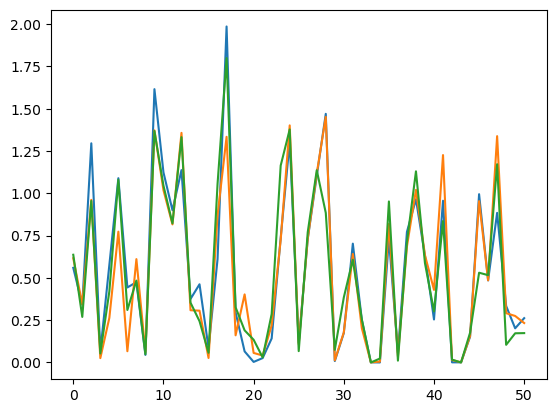

In [23]:
plt.plot(reference_sasa.mean(axis=0))
plt.plot(candidate_Aa_sasa.mean(axis=0))
plt.plot(candidate_Cb_sasa.mean(axis=0))
plt.show()

In [13]:
accessibility_weights = reference_sasa / reference_sasa.sum(axis=1).reshape(-1, 1)
accessibility_weights.shape

(5001, 51)

In [24]:
reference_rmsf = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/rmsf.xvg'))[:, 1]
candidate_Aa_rmsf = read_xvg_file(os.path.join(PATH_CANDIDATE_Aa, 'analysis/rmsf.xvg'))[:, 1]
candidate_Cb_rmsf = read_xvg_file(os.path.join(PATH_CANDIDATE_Cb, 'analysis/rmsf.xvg'))[:, 1]

reference_rmsf.shape, candidate_Aa_rmsf.shape, candidate_Cb_rmsf.shape

((227,), (227,), (227,))

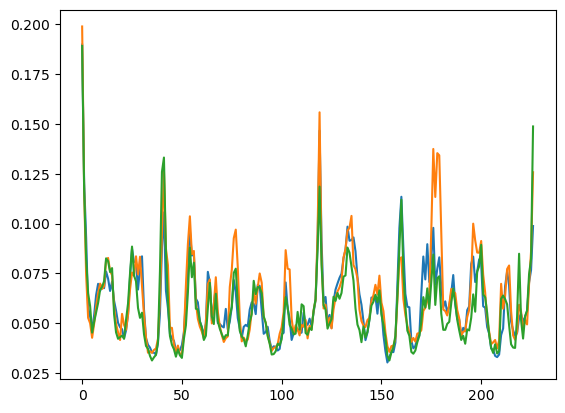

In [25]:
plt.plot(reference_rmsf)
plt.plot(candidate_Aa_rmsf)
plt.plot(candidate_Cb_rmsf)
plt.show()

In [38]:
reference_cdr_rmsf = np.hstack([reference_rmsf[val[0] - 1:val[1] - 1] for val in CDRS.values()])
candidate_Aa_cdr_rmsf = np.hstack([candidate_Aa_rmsf[val[0] - 1:val[1] - 1] for val in CDRS.values()])
candidate_Cb_cdr_rmsf = np.hstack([candidate_Cb_rmsf[val[0] - 1:val[1] - 1] for val in CDRS.values()])

In [43]:
movability_weights = reference_cdr_rmsf.mean() / reference_cdr_rmsf
print(movability_weights.shape)
print(movability_weights)

(51,)
[0.69718768 0.75593459 0.75593459 0.91186729 0.78613301 0.72971198
 1.07212516 1.34074553 0.98552377 0.75035574 0.63216499 0.72623716
 0.71938587 0.97762695 1.00832928 1.3739622  1.34964428 0.86530385
 1.06093777 1.16419698 1.46644042 1.35866195 1.3204312  1.29520003
 1.34666494 1.17315234 0.96985567 0.98552377 0.95767538 1.11321025
 0.92430184 1.07212516 1.38017922 1.69455338 2.01333074 1.38961097
 0.94141854 0.73058589 0.84727669 0.68008831 0.86285603 0.74033885
 1.84860368 1.77853999 1.38330888 1.28700256 0.88926999 0.80268318
 0.88539799 1.2008646  1.31191229]


In [51]:
wrmsd_Aa = np.sum(rmsd_Aa * accessibility_weights * movability_weights, axis=1)
wrmsd_Cb = np.sum(rmsd_Cb * accessibility_weights * movability_weights, axis=1)

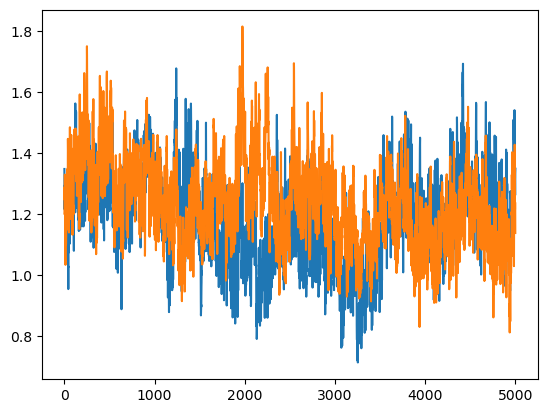

In [52]:
plt.plot(wrmsd_Aa)
plt.plot(wrmsd_Cb)
plt.show()

In [103]:
window_size = 200
smoothing_kernel = np.ones(window_size) / window_size

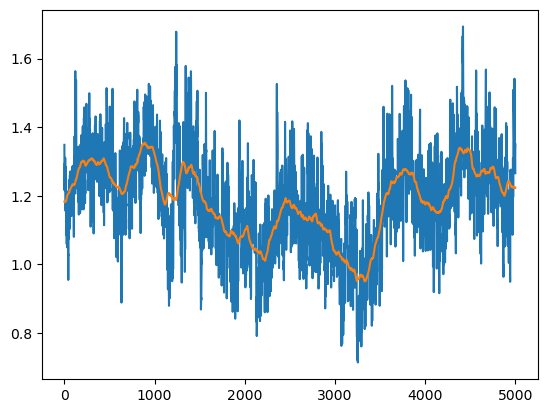

In [104]:
plt.plot(wrmsd_Aa)
plt.plot(np.convolve(np.pad(wrmsd_Aa, (window_size // 2, (window_size - 1) // 2), 'reflect'), 
                     smoothing_kernel, mode='valid'))
plt.show()

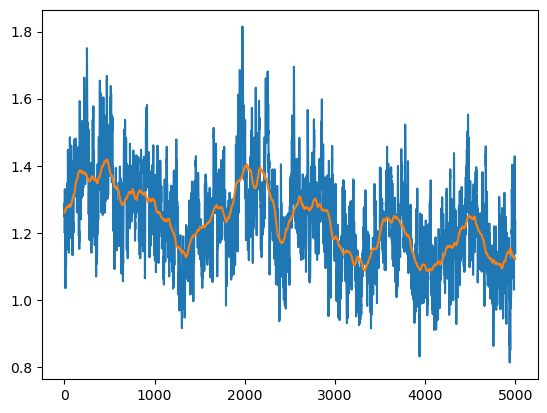

In [105]:
plt.plot(wrmsd_Cb)
plt.plot(np.convolve(np.pad(wrmsd_Cb, (window_size // 2, (window_size - 1) // 2), 'reflect'), 
                     smoothing_kernel, mode='valid'))
plt.show()

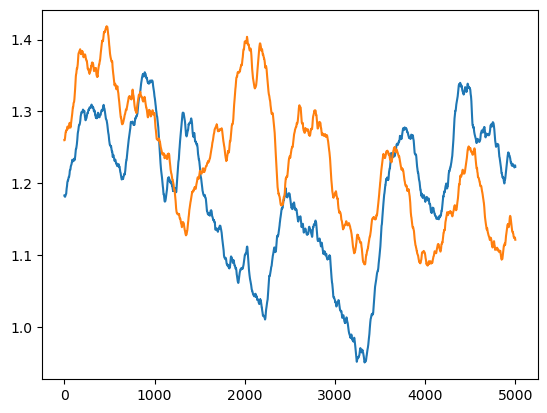

In [106]:
plt.plot(np.convolve(np.pad(wrmsd_Aa, (window_size // 2, (window_size - 1) // 2), 'reflect'), 
                     smoothing_kernel, mode='valid'))

plt.plot(np.convolve(np.pad(wrmsd_Cb, (window_size // 2, (window_size - 1) // 2), 'reflect'), 
                     smoothing_kernel, mode='valid'))

plt.show()

In [107]:
print(f'Mean wRMSD for candidate (A + a): {wrmsd_Aa.mean()}')
print(f'Mean wRMSD for candidate (C + b): {wrmsd_Cb.mean()}')

Mean wRMSD for candidate (A + a): 1.1856416394616929
Mean wRMSD for candidate (C + b): 1.2345469296259477


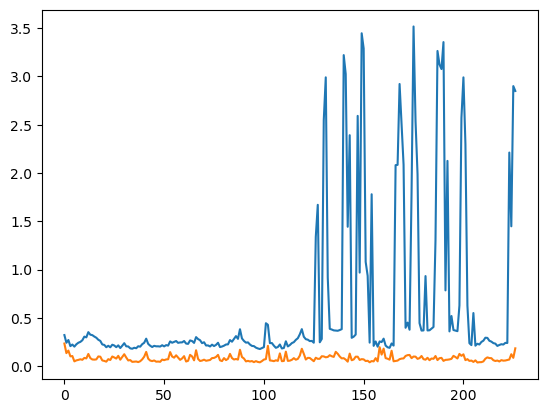

In [75]:
rmsf = read_xvg_file(os.path.join(PATH_CANDIDATE_AB, 'analysis/rmsf.xvg'))
rmsf_noPBC = read_xvg_file(os.path.join(PATH_CANDIDATE_AB, 'analysis/rmsf_noPBC.xvg'))
rmsdev = read_xvg_file(os.path.join(PATH_CANDIDATE_AB, 'analysis/rmsdev.xvg'))
rmsdev_noPBC = read_xvg_file(os.path.join(PATH_CANDIDATE_AB, 'analysis/rmsdev_noPBC.xvg'))

plt.plot(rmsf[:, 1])
plt.plot(rmsf_noPBC[:, 1])

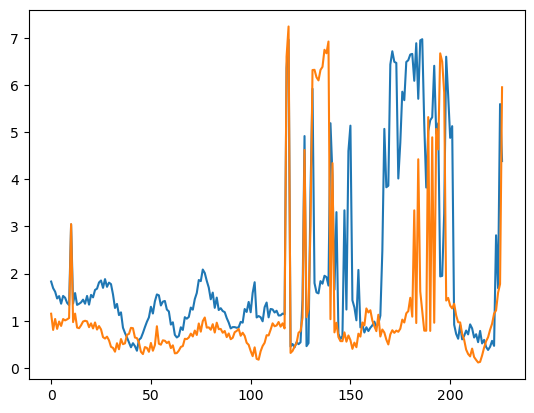

In [78]:
plt.plot(rmsdev[:, 1])
plt.plot(rmsdev_noPBC[:, 1])

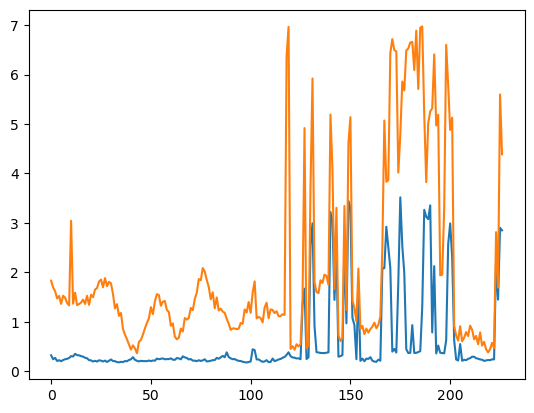

In [79]:
plt.plot(rmsf[:, 1])
plt.plot(rmsdev[:, 1])

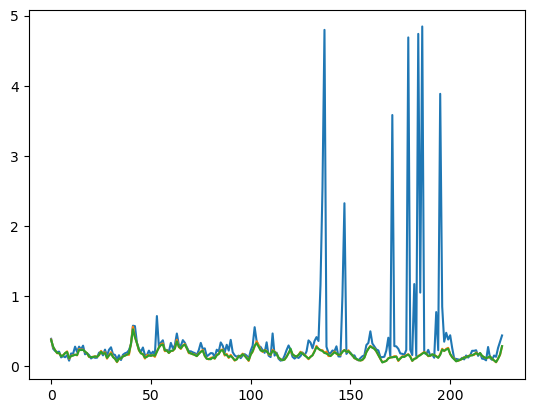

In [10]:
plt.plot(rmsdev_pr)
plt.plot(rmsdev_ca)
plt.plot(rmsdev_bb)

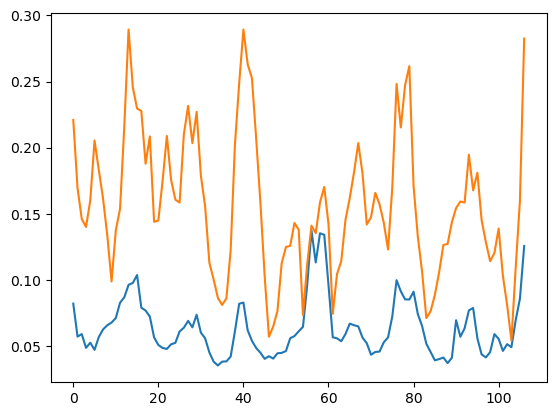

In [92]:
plt.plot(rmsf_ca[120:])
plt.plot(rmsdev_ca[120:])

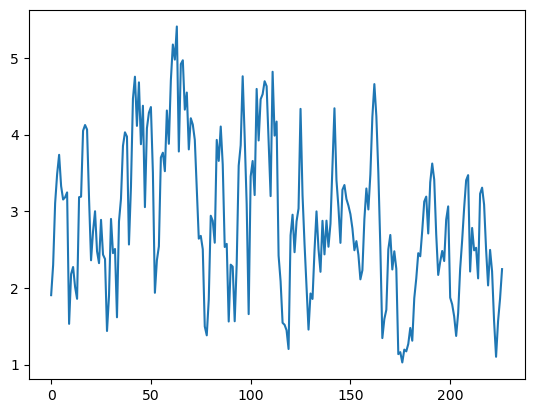

In [91]:
plt.plot(rmsdev_ca / rmsf_ca)